In [ ]:
# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""

# xarray opens the netcdf file
import xarray as xr
import requests
import io
import pandas as pd
from plotnine import *
import datetime

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")
# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header
start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

# Get time bounds properties of the .nc file, which aren't declared attributes
minyear = int(min(nc.year))
maxyear = int(max(nc.year))

# Now we convert the imported netcdf object to a pandas dataframe
ensemble_df = nc.to_dataframe().reset_index()
# Can't remember why I convert date to a string, but it was needed for grouping I think (won't work well with a datetime object)
# We also create a "date" column, because it makes more sense than a "days" column formatted as a date
# A "date" column also plays along nicely with the SILO dataset
ensemble_df["date"] = ensemble_df["days"].astype(str)
# Delete "days" column
ensemble_df = ensemble_df.drop(columns="days")


# Get SILO data to compare ensemble with it

# Set SILO url download link (specifying csv format)
silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"
# Download SILO data
httpreq = requests.get(silourl, verify=False)

# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas
silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))
# This is to remove the header row
silo_df = silo_df.iloc[1:]
# Set columns to correct format
silo_df["date"] = silo_df["date"].astype(str)
silo_df["rad"] = silo_df["rad"].astype(float)
silo_df["tmax"] = silo_df["tmax"].astype(float)
silo_df["tmin"] = silo_df["tmin"].astype(float)
silo_df["rain"] = silo_df["rain"].astype(float)
silo_df["vp"] = silo_df["vp"].astype(float)
silo_df["evap"] = silo_df["evap"].astype(float)


# Compare ensemble and SILO

# We calculate the mean of the ensemble as this is what we want to evaluate
ensemble_df_mean = ensemble_df.groupby(["date"]).mean().reset_index()

# ANALYSIS 

# Plot using ggplot2 for python (plotnine). Currently not too pretty, need to find how to mend the looks
(ggplot(ensemble_df_mean.where(ensemble_df_mean["rain"]>0.1))+
  geom_density(mapping= aes(x = "rain"), color="red", size=1) +
  geom_density(data=silo_df.where(silo_df["rain"]>0.1), mapping= aes(x = "rain"), color="white", size=1, linetype='dotted') +
  theme_minimal()+
  coord_cartesian(xlim =(0, 20))
  )

# Calculate ensemble performance metrics (based on http://www.cawcr.gov.au/projects/verification/)
# We won't use correlation as we're not interested in predicting daily weather but the actual pattern of climate
fcast_vs_obs = ensemble_df_mean.merge(silo_df, on= 'date')

fcast_vs_obs.rename(columns = {"date":"date", "ens":"ens", "rad_x":"rad.fcast","tmax_x":"tmax.fcast","rain_x":"rain.fcast","tmin_x":"tmin.fcast","rad_y":"rad.obs","tmax_y":"tmax.obs","tmin_y":"tmin.obs","rain_y":"rain.obs","vp":"vp.obs","evap":"evap.obs"}, inplace=True)

# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative
fcast_vs_obs["error"] = fcast_vs_obs["rain.fcast"] - fcast_vs_obs["rain.obs"]
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

# Multiplicative bias - Answers the question: How does the average forecast magnitude compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations
bias = fcast_vs_obs["rain.fcast"].mean() / fcast_vs_obs["rain.obs"].mean()
print (bias)

# Next, we need more metrics...






In [1]:
# %load stat_metrics_compare_ensemble_and_SILO.py
"""
Created on Tue Apr 23 14:12:09 2019

@author: nav00a
"""

import xarray as xr
import requests
import io
import pandas as pd
import datetime

In [2]:
# xarray opens the netcdf file

# type nc in the console to see a summary of the object incl. attributes, dimensions and variables

# Interesting behaviour from xarray: if we define a variable with name "days" and units "days since Jan 1st 1970",
# it automatically reads it in as a datetime object!! It won't do it otherwise, but since this is what we want,
# we just go with it.

nc = xr.open_dataset("../data/ensemble_siloaccess_s.nc")
print(nc)

<xarray.Dataset>
Dimensions:  (ens: 11, ensday: 216, year: 23)
Coordinates:
  * ensday   (ensday) float64 0.0 1.0 2.0 3.0 4.0 ... 212.0 213.0 214.0 215.0
  * year     (year) float64 1.99e+03 1.991e+03 1.992e+03 ... 2.011e+03 2.012e+03
  * ens      (ens) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0
Data variables:
    days     (ens, year, ensday) datetime64[ns] ...
    rad      (ens, year, ensday) float32 ...
    tmax     (ens, year, ensday) float32 ...
    rain     (ens, year, ensday) float32 ...
    tmin     (ens, year, ensday) float32 ...
Attributes:
    latitude:              -35.99
    longitude:             142.92
    hindcast_start_month:  4.0
    ensemble_members:      11.0


In [3]:
# Get some properties (attributes) from the netcdf file
# Attributes are values that the creator of the file has provided as a sort of header

start_month = nc.attrs["hindcast_start_month"]
lon = nc.attrs["longitude"]
lat = nc.attrs["latitude"]

print(start_month)
print(lon)
print(lat)

4.0
142.92
-35.99


In [4]:
# Get time bounds properties of the .nc file, which aren't declared attributes

minyear = int(min(nc.year))
maxyear = int(max(nc.year))

print(minyear)
print(maxyear)

1990
2012


In [5]:
# Now we convert the imported netcdf object to a pandas dataframe

ensemble_df = nc.to_dataframe().reset_index()

In [6]:
# Can't remember why I convert date to a string, but it was needed for grouping I think 
# (won't work well with a datetime object)
# We also create a "date" column, because it makes more sense than a "days" column formatted as a date
# A "date" column also plays along nicely with the SILO dataset

ensemble_df["date"] = ensemble_df["days"].astype(str)

In [7]:
# Delete "days" column

ensemble_df = ensemble_df.drop(columns="days")

In [9]:
# We calculate the mean of the ensemble as this is what we want to evaluate
# we won't be looking at each ensemble individually

ensemble_df_mean = ensemble_df.groupby(["date"]).mean().reset_index()
print(ensemble_df_mean)

            date   ens  ensday    year        rad       tmax      rain  \
0     1990-04-01   1.0     0.0  1995.0  19.469091  24.893637  0.000000   
1     1990-04-02   1.0     1.0  1995.0  19.637272  23.433636  0.000000   
2     1990-04-03   1.0     2.0  1995.0  19.849091  26.585455  0.000000   
3     1990-04-04   1.0     3.0  1995.0  18.021818  29.214544  0.004545   
4     1990-04-05   1.0     4.0  1995.0  14.961818  28.380001  1.159091   
5     1990-04-06   1.0     5.0  1995.0  14.653636  28.348181  1.214545   
6     1990-04-07   1.0     6.0  1995.0  14.489091  26.299999  1.662727   
7     1990-04-08   1.0     7.0  1995.0  16.201818  26.136364  0.938182   
8     1990-04-09   1.0     8.0  1995.0  12.909091  24.195454  2.799091   
9     1990-04-10   1.0     9.0  1995.0  14.780000  22.581818  0.451818   
10    1990-04-11   1.0    10.0  1995.0  14.810909  23.250000  0.630909   
11    1990-04-12   1.0    11.0  1995.0  14.275455  23.760908  0.871818   
12    1990-04-13   1.0    12.0  1995.0

In [10]:
# Get SILO data to compare ensemble with 
# Set SILO url download link (specifying csv format)

silourl = "https://dcdp.research.csiro.au/silogrid?lat="+ str(lat)  +"&lon=" + str(lon) +" &format=csv&start=" + str(minyear) +"0101&stop=" + str(maxyear) +"1231"
print(silourl)

https://dcdp.research.csiro.au/silogrid?lat=-35.99&lon=142.92 &format=csv&start=19900101&stop=20121231


In [11]:
# Download SILO data

httpreq = requests.get(silourl, verify=False)
print(httpreq)

C:\Users\zin005\AppData\Local\Continuum\anaconda3\lib\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


<Response [200]>


In [12]:
# Use the StringIO function to interpret the csv-like object as if it was saved to disk, then read_csv into pandas

silo_df = pd.read_csv(io.StringIO(httpreq.content.decode('utf-8')))
print(silo_df)

            date     rad   tmax   tmin   rain     vp   evap
0              -  MJ/m^2     oC     oC     mm    hPa     mm
1     1990-01-01   32.10  32.60  15.60   0.00  13.20   9.70
2     1990-01-02   28.60  38.10  12.80   0.00  11.90  10.60
3     1990-01-03   29.70  43.10  20.20   0.00   7.70  13.20
4     1990-01-04   31.80  27.00  11.50   0.00  10.70   8.70
5     1990-01-05   25.50  30.00  14.30   0.00  11.10   8.40
6     1990-01-06   26.20  30.80  13.90   0.00  12.70   8.40
7     1990-01-07   14.10  27.00  15.40   0.00  13.00   6.00
8     1990-01-08   20.20  29.60  14.20   0.00  11.20   7.50
9     1990-01-09   10.80  28.50  17.00   1.70  19.20   5.20
10    1990-01-10   12.10  31.20  18.60   1.10  20.00   5.90
11    1990-01-11   25.80  35.00  19.30   0.80  22.70   8.40
12    1990-01-12   29.10  34.90  20.40   0.50  17.80   9.40
13    1990-01-13   31.50  29.20  13.70   0.00  12.70   8.90
14    1990-01-14   21.70  27.10  10.40   0.00  11.00   7.20
15    1990-01-15   31.50  25.60   9.90  

In [13]:
# This is to remove the header row

silo_df = silo_df.iloc[1:]
print(silo_df)

            date    rad   tmax   tmin   rain     vp   evap
1     1990-01-01  32.10  32.60  15.60   0.00  13.20   9.70
2     1990-01-02  28.60  38.10  12.80   0.00  11.90  10.60
3     1990-01-03  29.70  43.10  20.20   0.00   7.70  13.20
4     1990-01-04  31.80  27.00  11.50   0.00  10.70   8.70
5     1990-01-05  25.50  30.00  14.30   0.00  11.10   8.40
6     1990-01-06  26.20  30.80  13.90   0.00  12.70   8.40
7     1990-01-07  14.10  27.00  15.40   0.00  13.00   6.00
8     1990-01-08  20.20  29.60  14.20   0.00  11.20   7.50
9     1990-01-09  10.80  28.50  17.00   1.70  19.20   5.20
10    1990-01-10  12.10  31.20  18.60   1.10  20.00   5.90
11    1990-01-11  25.80  35.00  19.30   0.80  22.70   8.40
12    1990-01-12  29.10  34.90  20.40   0.50  17.80   9.40
13    1990-01-13  31.50  29.20  13.70   0.00  12.70   8.90
14    1990-01-14  21.70  27.10  10.40   0.00  11.00   7.20
15    1990-01-15  31.50  25.60   9.90   0.00  10.90   8.30
16    1990-01-16  31.60  24.00   7.90   0.00   8.80   8.

In [14]:
# Set columns to correct format

silo_df["date"] = silo_df["date"].astype(str)
silo_df["rad"] = silo_df["rad"].astype(float)
silo_df["tmax"] = silo_df["tmax"].astype(float)
silo_df["tmin"] = silo_df["tmin"].astype(float)
silo_df["rain"] = silo_df["rain"].astype(float)
silo_df["vp"] = silo_df["vp"].astype(float)
silo_df["evap"] = silo_df["evap"].astype(float)

In [15]:
# check the type of the date column - this says it is a series - not sure if the code in the previous cell did anything

type(silo_df["date"])

pandas.core.series.Series

In [16]:
import re #regex

# the ensemble_df has days from April 1st to November 2nd (!!???) each year - a total of 216 days.
# to be able to compare the two data frames it is necessary to crop the silo_df so that it has the same days
# we use regex to do this

silo216_df = silo_df[silo_df['date'].str.contains(r'....-04-..|....-05-..|....-06-..|....-07-..|....-08-..|....-09-..|....-10-..|....-11-01|....-11-02')]
print(silo216_df)

            date   rad  tmax  tmin  rain    vp  evap
91    1990-04-01  20.3  23.9   8.0   0.0  11.5   4.2
92    1990-04-02  20.1  22.4  11.1   0.0  11.0   4.0
93    1990-04-03  20.1  26.0   8.4   0.0  11.2   4.5
94    1990-04-04  19.0  28.3  13.0   0.0  13.7   4.7
95    1990-04-05  19.0  29.1  14.0   0.0  14.4   4.8
96    1990-04-06  16.4  29.4  14.7   0.0  15.6   4.6
97    1990-04-07  16.2  24.3   9.9   0.0  11.9   3.9
98    1990-04-08  16.0  23.1   8.7   0.0  10.5   3.8
99    1990-04-09  18.4  26.0   8.8   0.0  13.4   4.2
100   1990-04-10  11.5  25.9  13.0   0.0  17.0   3.3
101   1990-04-11   6.2  23.8  17.4   0.0  18.8   2.4
102   1990-04-12  15.3  29.1  13.8   0.0  18.3   4.1
103   1990-04-13   9.3  29.1  15.3   0.0  14.9   4.1
104   1990-04-14  15.1  21.2  11.3   1.2  13.3   3.2
105   1990-04-15  16.7  19.3   6.5   0.0  10.2   3.3
106   1990-04-16  17.6  19.8   6.2   0.0  10.2   3.5
107   1990-04-17  17.7  21.1   6.8   2.1  10.8   3.6
108   1990-04-18  12.9  23.4   8.2   0.0  11.9

In [17]:
# choose the column "rain" from the ensemble data
earrayRain = ensemble_df_mean["rain"]
print(earrayRain)

0       0.000000
1       0.000000
2       0.000000
3       0.004545
4       1.159091
5       1.214545
6       1.662727
7       0.938182
8       2.799091
9       0.451818
10      0.630909
11      0.871818
12      0.125455
13      2.212727
14      5.693636
15      5.303637
16      1.230909
17      1.872727
18      0.017273
19      0.504545
20      0.658182
21      0.574545
22      0.590000
23      1.137273
24      0.773636
25      1.413636
26      0.359091
27      0.222727
28      0.006364
29      0.022727
          ...   
4938    0.006364
4939    0.671818
4940    0.728182
4941    0.337273
4942    0.105455
4943    0.707273
4944    0.220909
4945    0.002727
4946    0.014545
4947    0.227273
4948    1.457273
4949    1.364545
4950    1.530909
4951    0.288182
4952    0.233636
4953    0.611818
4954    0.520000
4955    1.230000
4956    1.551818
4957    0.382727
4958    0.711818
4959    0.526364
4960    4.210000
4961    2.845455
4962    2.626364
4963    0.484545
4964    0.027273
4965    0.0318

In [18]:
# choose the column "rain" from the silo data

sarrayRain = silo216_df["rain"]
print(sarrayRain)

91       0.0
92       0.0
93       0.0
94       0.0
95       0.0
96       0.0
97       0.0
98       0.0
99       0.0
100      0.0
101      0.0
102      0.0
103      0.0
104      1.2
105      0.0
106      0.0
107      2.1
108      0.0
109      0.0
110      0.0
111     11.0
112      1.0
113      1.5
114      0.0
115      0.1
116      0.0
117      0.0
118      0.0
119      0.0
120      1.0
        ... 
8313     0.0
8314     0.0
8315     2.9
8316     9.4
8317     0.0
8318     0.0
8319     0.0
8320     2.8
8321     2.1
8322     0.0
8323     0.2
8324     0.0
8325     0.3
8326     0.0
8327     0.0
8328     0.0
8329     0.0
8330     0.0
8331     0.0
8332     0.0
8333     0.0
8334     0.0
8335     0.0
8336     0.4
8337     0.0
8338     0.0
8339     0.0
8340     0.0
8341     3.0
8342     0.0
Name: rain, Length: 4968, dtype: float64


In [20]:
# I need to convert all the zeros to a positive number
# to use in the Kullback_Leibler divergence computation
# I can't have zero as the denominator

earrayRainplusone = earrayRain + 0.00000001
sarrayRainplusone = sarrayRain + 0.00000001
print(earrayRainplusone)
print(sarrayRainplusone)

91      1.000000e-08
92      1.000000e-08
93      1.000000e-08
94      1.000000e-08
95      1.000000e-08
96      1.000000e-08
97      1.000000e-08
98      1.000000e-08
99      1.000000e-08
100     1.000000e-08
101     1.000000e-08
102     1.000000e-08
103     1.000000e-08
104     1.200000e+00
105     1.000000e-08
106     1.000000e-08
107     2.100000e+00
108     1.000000e-08
109     1.000000e-08
110     1.000000e-08
111     1.100000e+01
112     1.000000e+00
113     1.500000e+00
114     1.000000e-08
115     1.000000e-01
116     1.000000e-08
117     1.000000e-08
118     1.000000e-08
119     1.000000e-08
120     1.000000e+00
            ...     
8313    1.000000e-08
8314    1.000000e-08
8315    2.900000e+00
8316    9.400000e+00
8317    1.000000e-08
8318    1.000000e-08
8319    1.000000e-08
8320    2.800000e+00
8321    2.100000e+00
8322    1.000000e-08
8323    2.000000e-01
8324    1.000000e-08
8325    3.000000e-01
8326    1.000000e-08
8327    1.000000e-08
8328    1.000000e-08
8329    1.000

In [23]:
# the Kullback–Leibler divergence (also called relative entropy) y variable
# is a measure of how one probability distribution is different 
# from a second, reference probability distribution.

# Kullback-Leibler = Σ(x(log(x/y)))

import numpy as np

kl1 = (earrayRain * np.log(earrayRainplusone/sarrayRainplusone)).sum()
print( "Model 1: ", round(kl1, 4))

kl2 = (sarrayRain * np.log(sarrayRainplusone/earrayRainplusone)).sum()
print("Model 2: ", round(kl2, 4))

Model 1:  35785.6335
Model 2:  10004.6366


In [25]:
# import the necessary packages to make some nice plots

import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

# %matplotlib inline sets the backend of matplotlib to the 'inline' backend: With this backend, 
# the output of plotting commands is displayed inline within frontends like the Jupyter notebook, 
# directly below the code cell that produced it.

%matplotlib inline

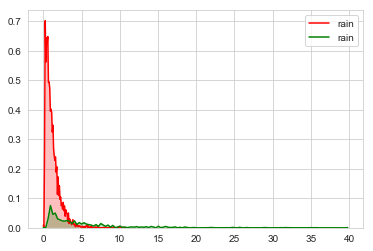

In [26]:
# this graph compares densities of each unique value of rainfall

sns.set_style('whitegrid')
ax = sns.kdeplot(earrayRain, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(sarrayRain, bw=0, color = 'green', shade = 'true')

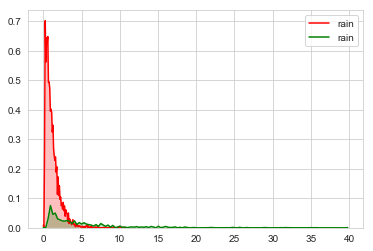

In [27]:
# this graph compares densities of each unique value of rainfall
# for any variable

variable = "rain"
earray = ensemble_df_mean[variable]
sarray = silo216_df[variable]

sns.set_style('whitegrid')
ax = sns.kdeplot(earray, bw=0, color = 'red', shade = 'true')
ax = sns.kdeplot(sarray, bw=0, color = 'green', shade = 'true')

In [29]:
# this will pull out rainfall over 0.1mm in the ensemble data

eArrayRainSig = [round(num,1) for num in ensemble_df_mean["rain"] if num > 0.1]
print(eArrayRainSig)

[1.2, 1.2, 1.7, 0.9, 2.8, 0.5, 0.6, 0.9, 0.1, 2.2, 5.7, 5.3, 1.2, 1.9, 0.5, 0.7, 0.6, 0.6, 1.1, 0.8, 1.4, 0.4, 0.2, 1.4, 1.3, 3.9, 0.6, 0.6, 0.3, 0.8, 0.4, 0.6, 1.4, 1.0, 0.3, 0.3, 0.6, 0.5, 0.9, 0.3, 1.4, 0.9, 1.3, 1.5, 0.8, 2.1, 0.7, 2.1, 0.3, 1.6, 0.5, 1.0, 0.3, 2.1, 3.0, 2.6, 3.0, 2.2, 1.3, 3.6, 1.3, 0.2, 0.6, 0.3, 0.7, 0.9, 1.7, 0.5, 0.7, 1.2, 0.3, 0.8, 0.8, 0.5, 0.7, 1.3, 1.8, 1.2, 0.6, 0.4, 1.0, 1.1, 1.0, 0.2, 3.1, 1.6, 1.9, 0.4, 0.5, 0.5, 1.7, 1.9, 1.2, 0.5, 0.5, 0.5, 1.0, 0.4, 0.3, 0.2, 0.5, 1.8, 0.8, 1.0, 1.2, 1.0, 0.3, 1.4, 0.5, 1.7, 0.4, 0.6, 0.5, 0.2, 0.2, 0.7, 0.7, 0.5, 0.4, 0.9, 0.8, 0.9, 1.1, 0.1, 1.4, 0.7, 0.1, 0.8, 0.2, 0.6, 0.2, 1.5, 1.2, 0.6, 1.3, 1.6, 0.2, 2.3, 1.5, 2.4, 1.3, 3.1, 4.3, 2.5, 1.1, 6.3, 1.9, 0.9, 2.0, 1.4, 0.3, 1.7, 3.5, 3.8, 1.7, 0.4, 1.4, 1.7, 2.5, 0.2, 0.6, 0.6, 1.8, 0.6, 2.3, 0.9, 1.1, 3.0, 2.1, 0.8, 0.9, 2.0, 0.2, 0.3, 0.3, 1.0, 1.5, 0.2, 0.2, 0.9, 1.3, 0.8, 1.0, 1.4, 5.4, 3.6, 1.1, 0.4, 0.3, 0.3, 0.4, 0.2, 1.4, 0.2, 0.4, 0.7, 0.2, 0.9, 0.2, 0.3,

In [30]:
# this will pull out rainfall over 0.1mm in the silo data

sArrayRainSig = [round(num,1) for num in silo216_df["rain"] if num > 0.1]
print(sArrayRainSig)

[1.2, 2.1, 11.0, 1.0, 1.5, 1.0, 6.0, 6.4, 0.6, 0.5, 0.4, 2.4, 0.5, 15.0, 0.4, 4.2, 3.5, 2.3, 4.3, 3.3, 0.8, 6.9, 0.5, 1.1, 5.1, 1.5, 0.6, 3.0, 0.4, 5.5, 0.5, 16.7, 0.6, 1.0, 0.8, 1.6, 0.4, 1.1, 0.2, 3.4, 1.8, 2.9, 0.5, 3.5, 0.9, 0.6, 1.8, 1.0, 2.5, 0.2, 5.7, 8.4, 2.9, 0.2, 4.2, 0.2, 3.2, 7.9, 0.9, 5.8, 2.4, 0.4, 1.3, 5.2, 1.1, 0.4, 6.8, 0.4, 17.1, 3.5, 1.0, 0.8, 5.8, 15.7, 0.5, 0.2, 5.3, 0.3, 7.5, 0.4, 0.3, 0.3, 0.2, 3.2, 7.0, 0.5, 0.2, 8.0, 0.4, 2.3, 10.3, 0.8, 0.2, 0.2, 7.7, 10.5, 0.3, 1.0, 6.3, 3.1, 0.8, 0.2, 5.5, 1.2, 0.3, 0.4, 3.4, 0.8, 4.6, 1.8, 0.3, 0.5, 1.0, 1.6, 1.5, 2.7, 0.5, 4.4, 1.4, 0.5, 2.6, 0.3, 1.1, 9.8, 3.0, 0.3, 0.5, 6.2, 7.5, 16.0, 1.0, 0.2, 6.2, 14.6, 0.7, 1.5, 7.3, 4.7, 0.6, 0.2, 0.3, 1.2, 8.1, 12.6, 0.5, 12.6, 0.5, 1.5, 5.8, 0.7, 0.3, 1.0, 1.5, 2.9, 3.2, 15.8, 21.9, 0.7, 7.7, 6.9, 3.0, 5.5, 1.4, 1.5, 2.2, 2.9, 0.3, 0.2, 0.3, 1.6, 2.9, 0.4, 5.4, 6.4, 0.2, 0.5, 2.9, 0.9, 4.8, 0.3, 4.0, 0.7, 0.7, 0.3, 4.5, 1.6, 0.9, 3.7, 7.0, 1.1, 6.2, 2.5, 1.7, 0.9, 1.6, 0.9, 0.8, 0

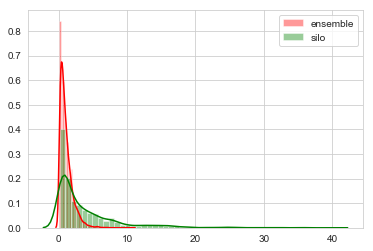

In [38]:
# plots the density for rainfall above 0.1mm

sns.distplot(eArrayRainSig, color="red", label = "ensemble")
sns.distplot(sArrayRainSig, color="green", label = "silo")
plt.legend()

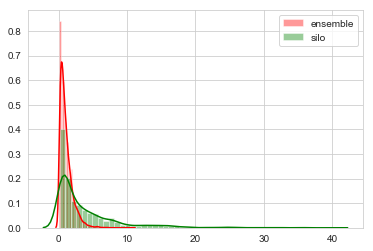

In [39]:
# plots the density for rainfall above 0.1mm with a normal distribution
sns.distplot( eArrayRainSig, color="red", label = "ensemble", norm_hist = "true")
sns.distplot( sArrayRainSig, color="green", label = "silo", norm_hist = "true")

plt.legend()

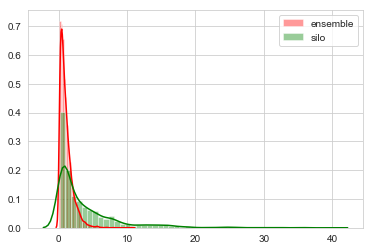

In [33]:
# use any of the variables as input for the plot
# if the variable is "rain" then we only want to use the values that are greater than 0.1
variable = "rain"

if variable == "rain":
    eArray = [num for num in ensemble_df_mean[variable] if num > 0.1]
    sArray = [num for num in silo216_df[variable] if num > 0.1]
else:
    earray = ensemble_df_mean[variable]
    sarray = silo_df[variable]
    
sns.distplot( eArray, color="red", label = "ensemble")
sns.distplot( sArray, color="green", label = "silo")
plt.legend()

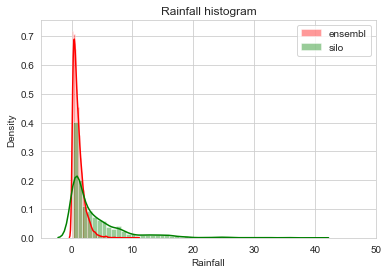

In [34]:
#label the axes and give the graph a name

fig, ax = plt.subplots()
sns.distplot( eArray, color="red", label = "ensembl")
sns.distplot( sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel='Rainfall', ylabel='Density')

plt.title("Rainfall histogram")

plt.legend()

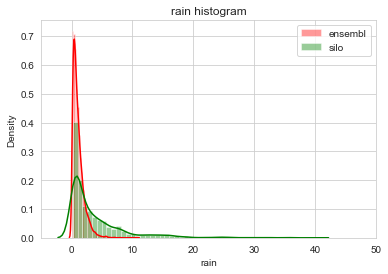

In [35]:
## rewrite the code to be able to use any of the variables in the datasets 

variable = "rain"

if variable == "rain":
    eArray = [num for num in ensemble_df_mean[variable] if num > 0.1]
    sArray = [num for num in silo216_df[variable] if num > 0.1]
else:
    earray = ensemble_df_mean[variable]
    sarray = silo216_df[variable]

fig, ax = plt.subplots()
sns.distplot( eArray, color="red", label = "ensembl")
sns.distplot( sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel = variable, ylabel='Density')

plt.title(variable + " histogram")

plt.legend()

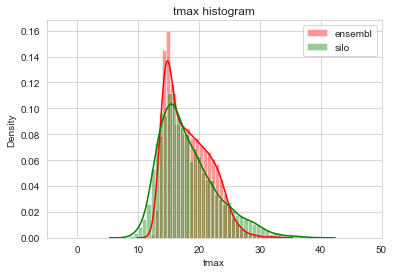

In [37]:
# run the code with a different variable

variable = "tmax"

if variable == "rain":
    eArray = [num for num in ensemble_df_mean[variable] if num > 0.1]
    sArray = [num for num in silo216_df[variable] if num > 0.1]
else:
    eArray = ensemble_df_mean[variable]
    sArray = silo216_df[variable]
    
#sns.distplot( eArray, color="red", label = "ensembl")
#sns.distplot( sArray, color="green", label = "silo")
#plt.legend()

fig, ax = plt.subplots()
sns.distplot( eArray, color="red", label = "ensembl")
sns.distplot( sArray, color="green", label = "silo")

ax.set_xlim(-5,50)
ax.set(xlabel = variable, ylabel='Density')

plt.title(variable + " histogram")

plt.legend()

In [ ]:
# Calculate ensemble performance metrics (based on http://www.cawcr.gov.au/projects/verification/)
# We won't use correlation as we're not interested in predicting daily weather but the actual pattern of climate
fcast_vs_obs = ensemble_df_mean.merge(silo216_df, on= 'date')

fcast_vs_obs.rename(columns = {"date":"date", "ens":"ens", "rad_x":"rad.fcast","tmax_x":"tmax.fcast","rain_x":"rain.fcast","tmin_x":"tmin.fcast","rad_y":"rad.obs","tmax_y":"tmax.obs","tmin_y":"tmin.obs","rain_y":"rain.obs","vp":"vp.obs","evap":"evap.obs"}, inplace=True)

In [ ]:
# Mean error - Answers the question: What is the average forecast error?
# We don't really want this for AgScore but it's informative
fcast_vs_obs["error"] = fcast_vs_obs["rain.fcast"] - fcast_vs_obs["rain.obs"]
mean_error = fcast_vs_obs["error"].mean()
print (mean_error)

In [ ]:
# Multiplicative bias - Answers the question: How does the average forecast magnitude compare to the average observed magnitude?
# Bias = mean of forecast divided by mean of observations
bias = fcast_vs_obs["rain.fcast"].mean() / fcast_vs_obs["rain.obs"].mean()
print (bias)

# Next, we need more metrics...